In [1]:
import sys
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("calibration_modules/")
from decoupled_linear import DecoupledLinear

In [2]:
data_dir = "data/"
output_dir = "output_files/case1/"
model_dir = "../lcls_cu_injector_nn_model/"

## Load Normalized Calibration Data and Define In- & Outputs

In [3]:
input_names = ["SOLN:IN20:121:BACT", "QUAD:IN20:121:BACT", "QUAD:IN20:122:BACT"]
output_names = ["OTRS:IN20:571:XRMS", "OTRS:IN20:571:YRMS"]
x_n = torch.load(data_dir + "normalized_calibration_inputs.pt")
y_n = torch.load(data_dir + "normalized_calibration_outputs.pt")
x_n.shape, y_n.shape

(torch.Size([834, 16]), torch.Size([834, 5]))

## Load LUME-Model

In [4]:
# create base model
base_model = torch.load(model_dir + "model/model.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_dir + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_dir + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_dir + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_dir + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_dir + "model/pv_variables.yml"))

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_dir + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs[:2],
)

## Create Model with Calibration Layers

In [5]:
# create model
cal_model = DecoupledLinear(
    model=base_model,
    x_size=len(lume_model.features),
    y_size=len(lume_model.outputs),
    x_mask=[ele in input_names for ele in lume_model.features],
    y_mask=[ele in output_names for ele in lume_model.outputs],
)
cal_model

DecoupledLinear(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=300, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=True)
    (12): ELU(alpha=1.0)
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=200, bias=True)
    (15): ELU(alpha=1.0)
    (16): Dropout(p=0.05, inplace=False)
    (17): Linear(in_features=200, out_features=100, bias=True)
    (18): ELU(alpha=1.0)
    (19): Dropout(p=0.05, inplace=False)
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ELU(alpha=1.0)
    (22): Linear(in_f

In [6]:
# deactivate gradients in base model and put in eval mode
cal_model.model.requires_grad_(False)
cal_model.model.eval()
cal_model.model.training

False

In [7]:
# initial parameter values
for name in cal_model.calibration_parameter_names:
    print(f"{name}: ", getattr(cal_model, name).data)

x_offset:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
x_scale:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
y_offset:  tensor([0., 0., 0., 0., 0.])
y_scale:  tensor([1., 1., 1., 1., 1.])


## Train Calibration Layers

In [8]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [9]:
# define dataloader
pin_memory = True
batch_size = 10
trainset = Dataset(x_n, y_n)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=0, pin_memory=pin_memory)

In [10]:
# training configuration
reg = 1e-2
lr = 1e-4
n_epochs = int(1e5)
optimizer = torch.optim.Adam(cal_model.raw_calibration_parameters, lr=lr, weight_decay=reg)
# criterion = torch.nn.MSELoss(reduction="sum")
criterion = torch.nn.L1Loss(reduction="sum")

In [11]:
# training loop
train_losses, full_losses = [], []
print("{:8s} {:>12s} {:>12s} {:>12s}".format("EPOCH", "TRAIN_LOSS", "FULL_LOSS", "ETA"))
t0 = time.time()
best_loss = float("inf")

for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
        inputs, labels = batch_data
        optimizer.zero_grad()
        outputs = cal_model(inputs)
        loss = criterion(outputs[:, :2], labels[:, :2])  # use only transverse beam size
        loss.backward()
        optimizer.step()
        if i == 0:
            # store loss
            train_losses.append(loss.item())
            full_outputs = cal_model(x_n)
            full_loss = criterion(full_outputs[:, :2], y_n[:, :2])
            full_losses.append(full_loss.item())
            # print info
            if epoch % (n_epochs // 10) == 0:
                t_avg = (time.time() - t0) / (epoch + 1)
                t_r = (n_epochs - epoch - 1) * t_avg / 60  # in minutes
                if t_r <= 1.0:
                    t_info = "{:.2f} sec".format(60 * t_r)
                else:
                    t_info = "{:.2f} min".format(t_r)
                info = "{:<8d} {:12.5f} {:12.5f} {:>12s}".format(epoch, loss, full_loss, t_info)
                if full_loss < best_loss:
                    info = "\033[0;32m" + info + '\x1b[0m'
                print(info)
                if full_loss < best_loss:
                    best_loss = full_loss

t_total = time.time() - t0
t_r = t_total / 60  # in minutes
if t_r <= 1.0:
    t_info = "{:.2f} sec".format(60 * t_r)
else:
    t_info = "{:.2f} min".format(t_r)
print("Total runtime: {}".format(t_info))

EPOCH      TRAIN_LOSS    FULL_LOSS          ETA
0             0.83600    113.10418    32.66 min
10000         0.46214     19.23765   116.41 min
20000         0.17596     19.22916   104.43 min
30000         0.17709     19.22829    91.46 min
40000         0.17686     19.22745    78.03 min
50000         0.32325     19.22788    64.58 min
60000         0.35328     19.23047    51.49 min
70000         0.21477     19.23050    38.53 min
80000         0.18366     19.22702    25.65 min
90000         0.26617     19.23441    12.75 min
Total runtime: 126.99 min


In [12]:
# save model and losses to file
if criterion.__class__.__name__ == "MSELoss":
    loss_name = "mse"
elif criterion.__class__.__name__ == "L1Loss":
    loss_name = "mae"
else:
    raise ValueError("Unknown loss function!")
file_name = "{}_bs={:d}_reg={:.0e}_lr={:.0e}_n={:d}k".format(loss_name, batch_size, reg, lr, int(n_epochs / 1e3))
torch.save(cal_model, output_dir + file_name + "_model.pt")
torch.save(torch.FloatTensor([train_losses, full_losses]), output_dir + file_name + "_losses.pt")

## Analyze Training Results

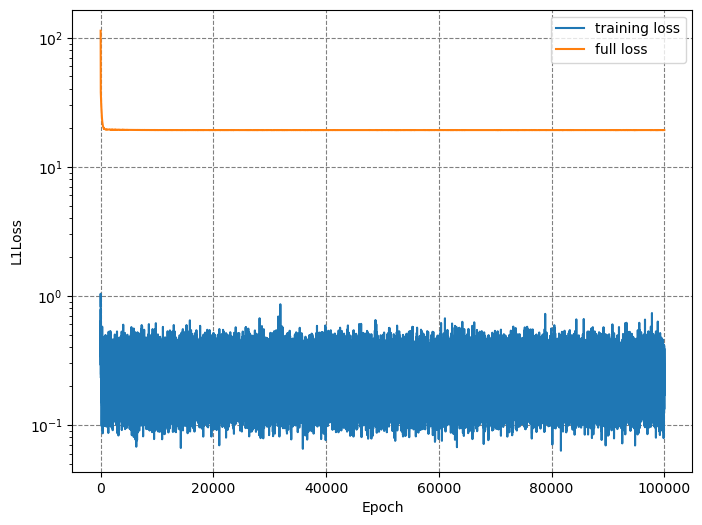

In [13]:
# plot training process
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_xlabel("Epoch")
ax.plot(train_losses, c="C0", label="training loss")
ax.plot(full_losses, c="C1", label="full loss")
ax.set_ylabel(criterion.__class__.__name__)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.set_yscale("log")
ax.grid(color="gray", linestyle="dashed")
fig.savefig(output_dir + file_name + "_losses.png")

In [14]:
# parameter values after training
for name in cal_model.calibration_parameter_names:
    print(f"{name}: ", getattr(cal_model, name).data)

x_offset:  tensor([ 0.0000,  0.0000,  0.0000, -0.1580,  0.3566,  0.1357,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
x_scale:  tensor([1.0000, 1.0000, 1.0000, 1.1518, 0.9085, 1.0161, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
y_offset:  tensor([0.0668, 0.0055, 0.0000, 0.0000, 0.0000])
y_scale:  tensor([0.1433, 0.7468, 1.0000, 1.0000, 1.0000])


In [15]:
# calculate calibrated normalized predictions
with torch.no_grad():
    predictions_n_cal = cal_model(x_n)
predictions_n_cal.shape

torch.Size([834, 5])

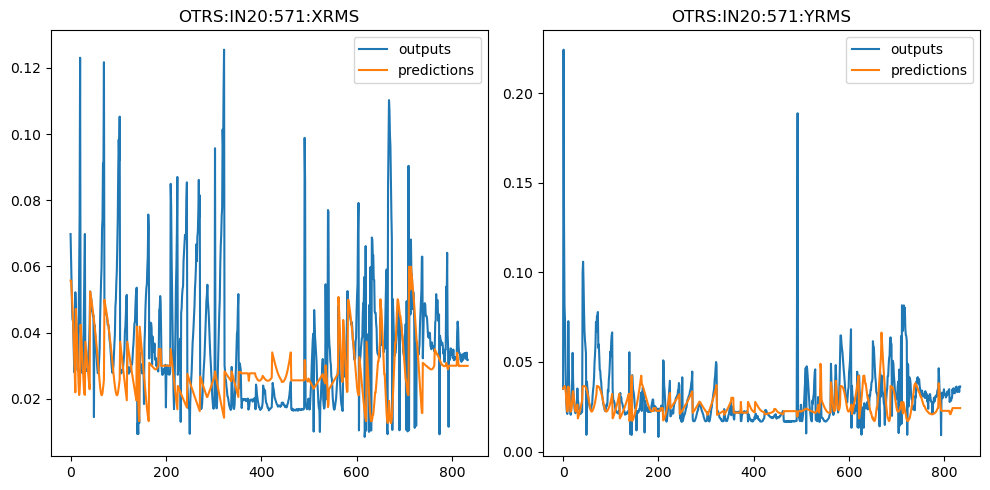

In [16]:
# plot example data and predictions
nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for i, output_name in enumerate(lume_module.output_order):
    x_axis = torch.arange(y_n.shape[0])
    ax[i].plot(x_axis, y_n[:, i], "C0-", label="outputs")
    ax[i].plot(x_axis, predictions_n_cal[:, i], "C1-", label="predictions")
    ax[i].legend()
    ax[i].set_title(output_name)
fig.tight_layout()
fig.savefig(output_dir + file_name + "_predictions.png")

### Check 1D Scans

In [17]:
# create LUME-model
cal_lume_model = PyTorchModel(
    model_file=output_dir + file_name + "_model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

In [18]:
# wrap in LUMEModule
cal_lume_module = LUMEModule(
    model=cal_lume_model,
    feature_order=cal_lume_model.features,
    output_order=cal_lume_model.outputs,
)

In [19]:
# define objective models
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)
cal_objective_model = ObjectiveModel(cal_lume_module)

In [20]:
# create reference point
x_default = torch.tensor([input_variables[key].default for key in input_variables.keys()], dtype=torch.double)

In [21]:
# define 1D scan sample function
def scan_x(name, n_samples=1000):
    idx = list(input_variables.keys()).index(name)
    v_lim = input_variables[name].value_range
    samples = x_default.repeat(n_samples, 1)
    samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples, dtype=x_default.dtype)
    return samples

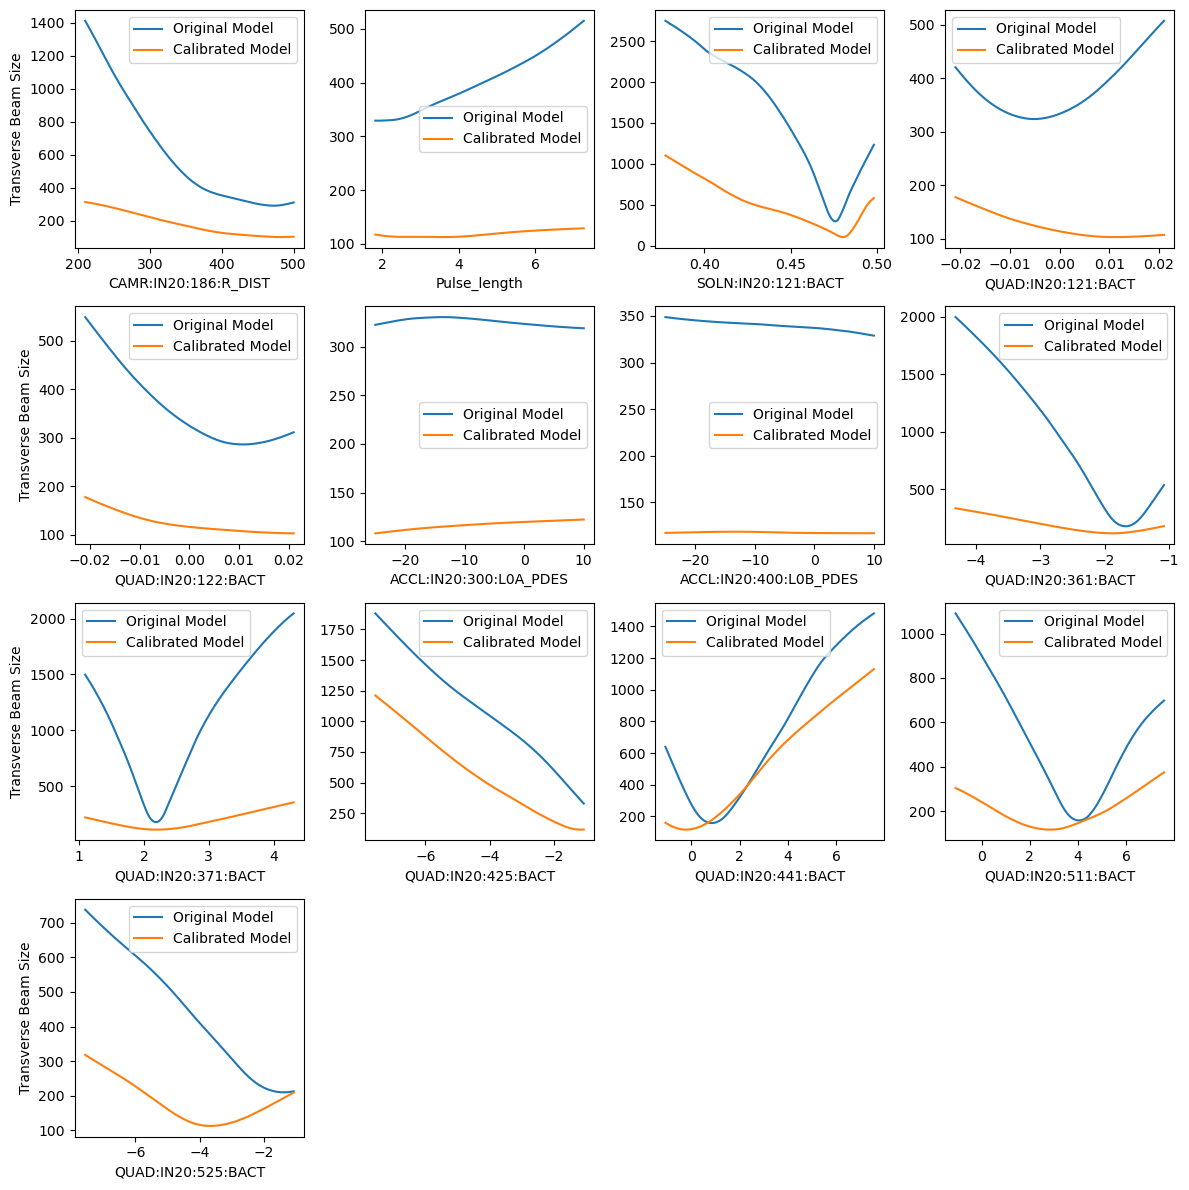

In [22]:
# compare 1D scans for original and calibrated model
nrows, ncols = 4, 4
figsize = (12, 12 * nrows / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=figsize)
n_skip = 0
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i + n_skip >= len(input_variables.keys()):
        ax_i.axis('off')
    else:
        name = list(input_variables.keys())[i + n_skip]
        v_lim = input_variables[name].value_range

        while not v_lim[0] < v_lim[1]:
            n_skip += 1
            name = list(input_variables.keys())[i + n_skip]
            v_lim = input_variables[name].value_range

        # compute 1D scans
        x_scan = scan_x(name=name)
        y_scan = objective_model(x_scan).detach()
        y_scan_cal = cal_objective_model(x_scan).detach()

        # plot data
        idx = list(input_variables.keys()).index(name)
        ax_i.plot(x_scan[:, idx], y_scan, "C0", label="Original Model")
        ax_i.plot(x_scan[:, idx], y_scan_cal, "C1", label="Calibrated Model")
        ax_i.set_xlabel(name)
        ax_i.legend()
        if i % ncols == 0:
            ax_i.set_ylabel("Transverse Beam Size")
fig.tight_layout()
fig.savefig(output_dir + file_name + "_1d_scan.png")